In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.patches import Circle, Ellipse
from scipy.stats import gamma, describe

import genexpr
from genexpr.twostagemodel import TwoStageModel
from genexpr.threestagemodel import ThreeStageModel
from genexpr.utils import KL_div, NBinom

params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
         'axes.titlesize':25}
pylab.rcParams.update(params)

# Part 1: Simulation of paper results
## Two-stage model

- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$

In [2]:
twostage = TwoStageModel()

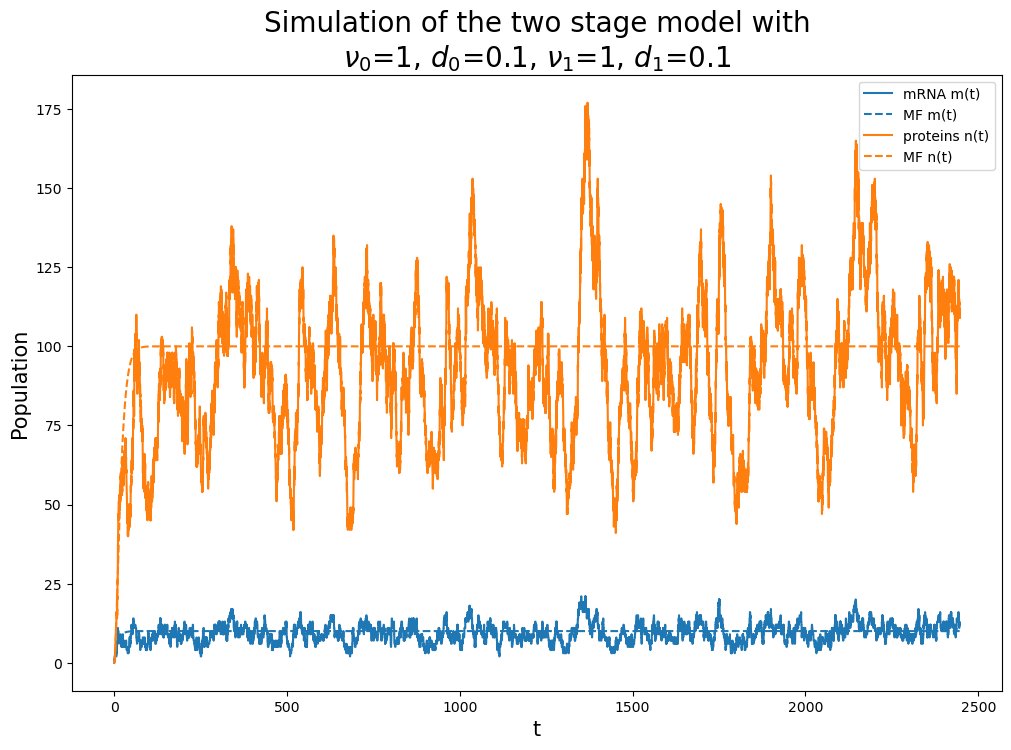

In [4]:
# initializations
t = 0.0
x = np.array([0,0])

nu0, d0, nu1, d1 = 1, 0.1, 1, 0.1
args = [nu0, d0, nu1, d1]


# Gillespie iterations
tstat=2.0e3
(m_t, n_t), t_t = twostage.Gillespie_simulation(x, t, tstat, 10000, args, keep_transient=True)


# Mean field solution
m_MF_t, n_MF_t = twostage.mean_field_prediction(np.array([0,0]), t_t, args)


# plots
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(t_t, m_t, label="mRNA m(t)")
ax.plot(t_t, m_MF_t, "--", color="C0", label="MF m(t)")
ax.plot(t_t, n_t, label="proteins n(t)")
ax.plot(t_t, n_MF_t, "--", color="C1", label="MF n(t)")

ax.set_title("Simulation of the two stage model with\n" + fr"$\nu_0$={nu0}, $d_0$={d0}, $\nu_1$={nu1}, $d_1$={d1}", fontsize=20)
ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("Population", fontsize=15)
ax.legend()

### Figure 1B


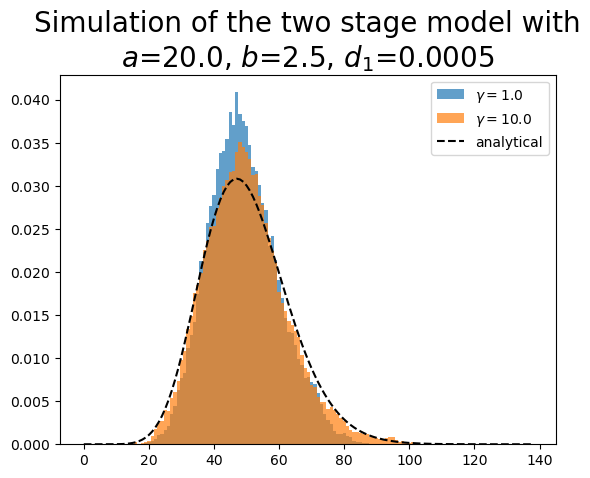

In [5]:
# gamma = 1.0
gamma, a, b, d1 = 1.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}", fontsize=20)
plt.legend()

### Figure 1C


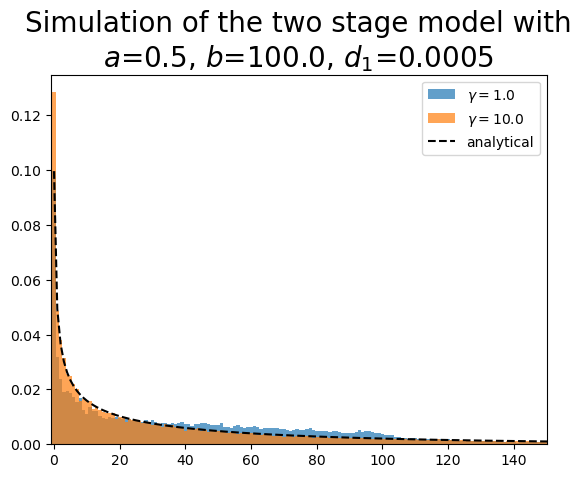

In [6]:
# gamma = 1.0
gamma, a, b, d1 = 1.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1 = 10.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tstat = 10.0/d1
(_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.xlim(-1,150)
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}", fontsize=20)
plt.legend()

### Figure 1D

In [7]:
gammas = np.logspace(-2, 2, num=15, base=10)
args_ = [(20.0, 2.5, 5e-4), (0.5, 100.0, 5e-4)]
res = {}

for arg_ in args_:
    res[f"{arg_[0]}_{arg_[1]}"] = {"D_KL":[], "gamma":[]}

    for gamma_ in gammas:
        a_, b_, d1_ = arg_
        args = (a_*d1_, gamma_*d1_, b_*gamma_*d1_, d1_)
        tstat_ = 10.0/d1_

        (_, n_hist), _ = twostage.Gillespie_simulation(np.array([0,0]), 0, tstat_, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
        h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True)
        n0 = np.arange(len(h_)+30)
        fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
        plt.clf()

        res[f"{arg_[0]}_{arg_[1]}"]["D_KL"].append(KL_div(h_, fn_analytical[:len(h_)]))
        res[f"{arg_[0]}_{arg_[1]}"]["gamma"].append(gamma_)

<Figure size 640x480 with 0 Axes>

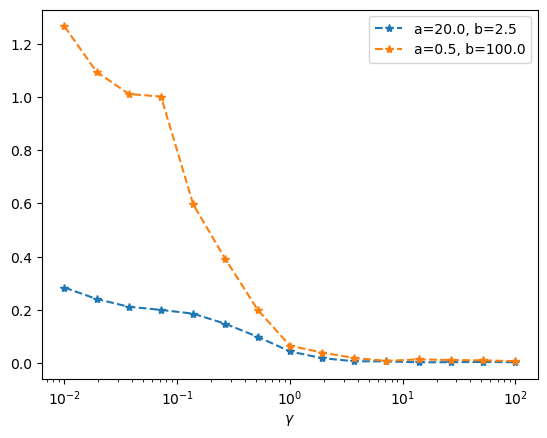

In [8]:
for (a_,b_,_) in args_:
    data = res[f"{a_}_{b_}"]
    plt.plot(data["gamma"], data["D_KL"], "*--", label=f"a={a_}, b={b_}")
plt.xscale("log")
plt.xlabel("$\gamma$")
plt.legend()

### Figure 2A

In [5]:
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tslice = np.array([0.01, 0.2, 0.8, 2, 10]) / d1

(_, n_hist) = twostage.Gillespie_simulation_transient(np.array([0,0]), 0, tslice, Nsim=1000, args=args)

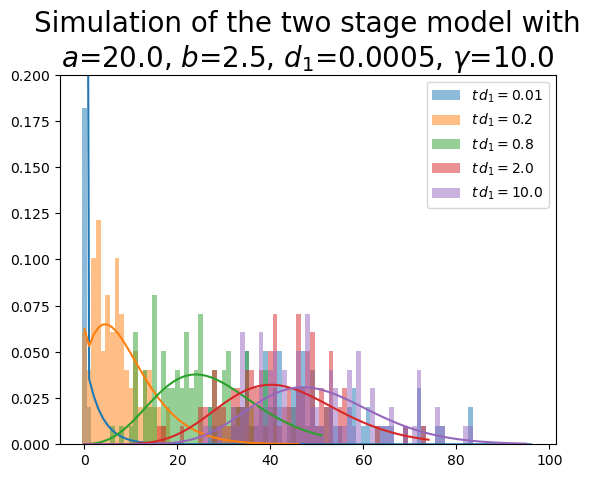

In [6]:
for t_, n_t in enumerate(n_hist):
    plt.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tslice[t_]*d1, 2)}")

    n0 = np.arange(max(n_t))
    plt.plot(n0, twostage.analytical_transient(n0, tslice[t_], np.identity(1)[0,:], args=args, normalize=True), ls="-", c="C"+str(t_))

plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\gamma$={gamma}", fontsize=20)
plt.ylim(0,0.2)
plt.legend()

### Figure 2B

In [11]:
gamma, a, b, d1 = 10.0, 0.5, 100.0, 5e-4
args = (a*d1, gamma*d1, b*gamma*d1, d1)
tslice = np.array([0.01, 0.2, 0.8, 2, 10]) / d1

(_, n_hist) = twostage.Gillespie_simulation_transient(np.array([0,50]), 0, tslice, Nsim=100, args=args)

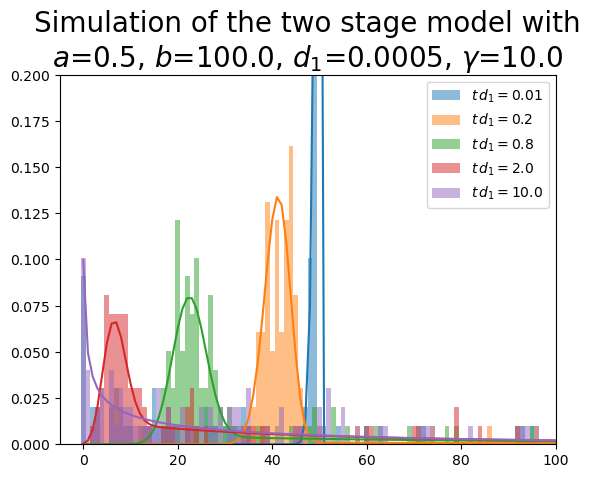

In [12]:
for t_, n_t in enumerate(n_hist):
    plt.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tslice[t_]*d1, 2)}")

    n0 = np.arange(max(n_t))
    plt.plot(n0, twostage.analytical_transient(n0, tslice[t_], np.identity(51)[50,:], args=args, normalize=True), c="C"+str(t_), ls="-")

plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\gamma$={gamma}", fontsize=20)
plt.xlim(-5, 100)
plt.ylim(0, 0.2)
plt.legend()

### Figure 2C

In [12]:
taus = np.logspace(-2, 1, num=15, base=10)
args_ = [(10.0, 20.0, 2.5, 5e-4), (10.0, 0.5, 100.0, 5e-4)]
x0s = [np.array([0,0]), np.array([0,50])]
res = {}

for x0_, arg_ in zip(x0s, args_):
    res[f"{arg_[1]}_{arg_[2]}"] = {"D_KL":[], "tau":[]}

    
    gamma_, a_, b_, d1_ = arg_
    args = (a_*d1_, gamma_*d1_, b_*gamma_*d1_, d1_)
    
    n_hists = twostage.Gillespie_simulation_transient(x0_, 0, taus/d1_, Nsim=1000, args=args)[1,:,:]
    
    # compute KL divergence for each tau (after having computed all of them once)
    for it, tau_ in enumerate(taus):
        h_, n_, _ = plt.hist(n_hists[it], bins=np.arange(start=-0.5, stop=max(n_hists[it])+0.5, step=1), density=True)
        n0 = np.arange(len(h_)+30)
        fn_analytical = twostage.analytical_transient(n0, tau_/d1_, np.identity(int(x0_[1])+1)[int(x0_[1]),:], args, normalize=True)
        plt.clf()

        res[f"{arg_[1]}_{arg_[2]}"]["D_KL"].append(KL_div(h_, fn_analytical[:len(h_)]))
        res[f"{arg_[1]}_{arg_[2]}"]["tau"].append(tau_)

<Figure size 640x480 with 0 Axes>

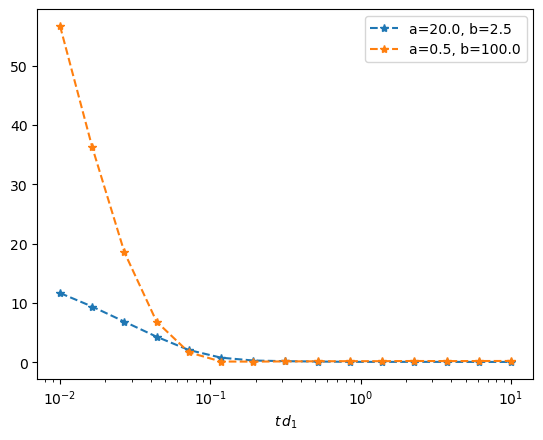

In [13]:
for (_,a_,b_,_) in args_:
    data = res[f"{a_}_{b_}"]
    plt.plot(data["tau"], data["D_KL"], "*--", label=f"a={a_}, b={b_}")
plt.xscale("log")
plt.xlabel("$t\, d_1$")
plt.legend()

### Figure 2D

In [16]:
taus = np.linspace(0, 5, num=20)
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
mu_ = 50
noises = np.linspace(0.2, 1.0, num=9)
eta_stat = np.sqrt((1+b)/(a*b))
res = {}

for eta_ in noises:
    res[f"eta0_{eta_}"] = {"eta":[], "tau":[]}

    for tau_ in taus:
        args = (a*d1, gamma*d1, b*gamma*d1, d1)

        n0 = np.arange(150)
        fn_analytical = twostage.analytical_transient(n0, tau_/d1, NBinom(n0, mu_, eta_), args, normalize=True)
        mean_dist = np.average(n0, weights=fn_analytical)
        std_dist = np.sqrt(np.average((n0-mean_dist)**2, weights=fn_analytical))
        plt.clf()

        res[f"eta0_{eta_}"]["eta"].append(std_dist/mean_dist)
        res[f"eta0_{eta_}"]["tau"].append(tau_)

<Figure size 640x480 with 0 Axes>

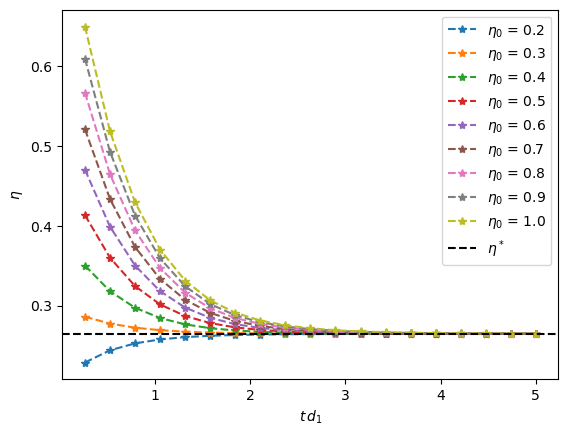

In [17]:
for eta_ in noises:
    data = res[f"eta0_{eta_}"]
    plt.plot(data["tau"], data["eta"], "*--", label=f"$\eta_0$ = {round(eta_,2)}")

plt.axhline(eta_stat, c="k", ls="--", label="$\eta^*$")
plt.xlabel("$t\, d_1$")
plt.ylabel("$\eta$")
plt.legend()

In [18]:
# compute also SIMULATION of protein noise

## Three-stage model
- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$
- $\kappa_0 = K_0/d_1$
- $\kappa_1 = K_1/d_1$

In [19]:
threestage = ThreeStageModel()

### Figure 3B

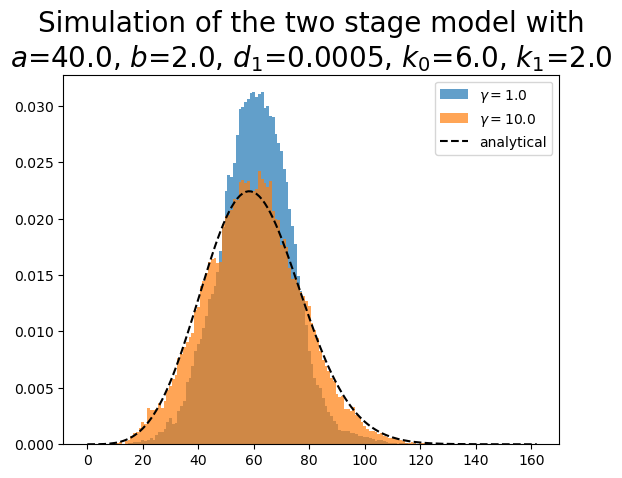

In [20]:
# gamma = 1.0
gamma, a, b, d1, k0, k1 = 1.0, 40.0, 2.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1, k0, k1 = 10.0, 40.0, 2.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $k_0$={k0}, $k_1$={k1}", fontsize=20)
plt.legend()

### Figure 3C

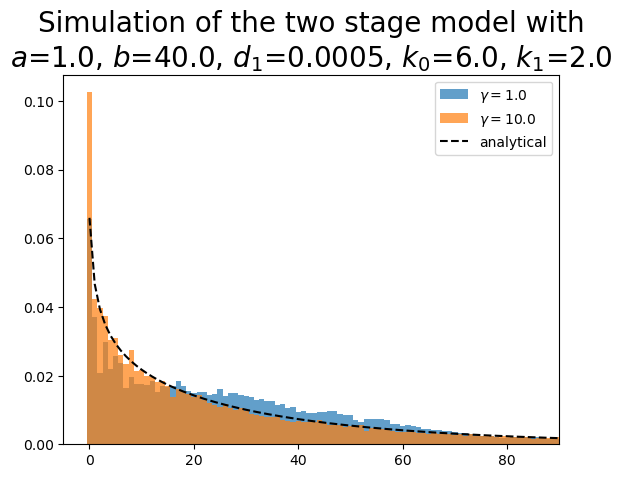

In [21]:
# gamma = 1.0
gamma, a, b, d1, k0, k1 = 1.0, 1.0, 40.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1, k0, k1 = 10.0, 1.0, 40.0, 5e-4, 6.0, 2.0
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $k_0$={k0}, $k_1$={k1}", fontsize=20)
plt.xlim(-5, 90)
plt.legend()

### Figure 3D

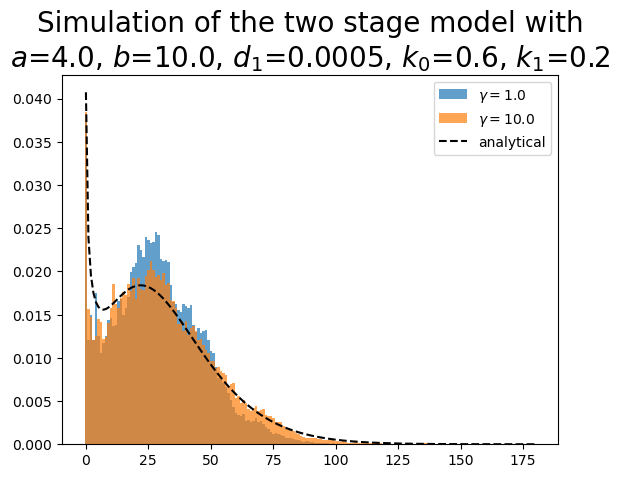

In [22]:
# gamma = 1.0
gamma, a, b, d1, k0, k1 = 1.0, 4.0, 10.0, 5e-4, 0.6, 0.2
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(n_hist)

# gamma = 10.0
gamma, a, b, d1, k0, k1 = 10.0, 4.0, 10.0, 5e-4, 0.6, 0.2
args = (a*d1, gamma*d1, b*gamma*d1, d1, k0*d1, k1*d1)
tstat = 10.0/d1
(_, n_hist, _), _ = threestage.Gillespie_simulation(np.array([0,0,0]), 0, tstat, Nsim=100000, args=args, dt=0.01/d1, keep_transient=False)
h_, n_, _ = plt.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.7)
max_n = max(max_n, max(n_hist))


# analytical plot
n0 = np.arange(max_n+30)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
plt.plot(n0, fn_analytical, "--", c="black", label="analytical")
plt.title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $k_0$={k0}, $k_1$={k1}", fontsize=20)
plt.legend()

# Part 2: study of real data

In [2]:
data = pd.read_csv("data/data_LN_PST_MB.csv", index_col=0).T
#data

In [3]:
data_nondiff = data[:int(data.shape[0]/6.0)]
data_diff = data[int(data.shape[0]*5.0/6.0):]

fancy_indices = [1,2,8,10]

Text(0.5, 1.0, 'After differentiation')

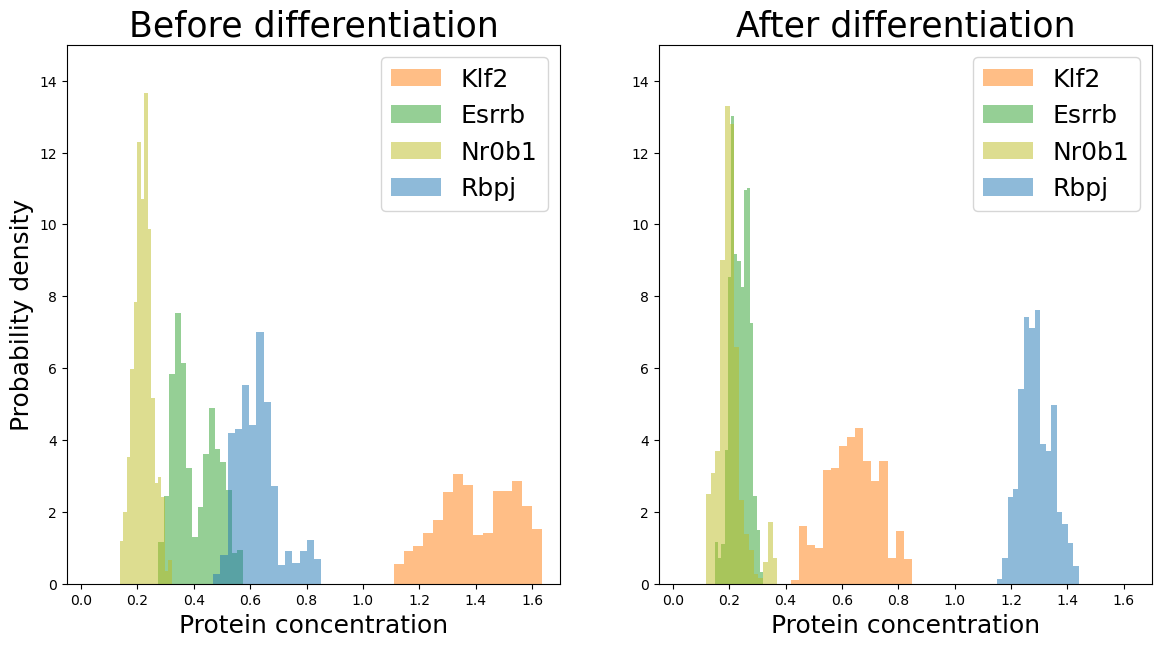

In [4]:
fig, axs = plt.subplots(1,2, figsize=(14,7))

for ii in fancy_indices:
    axs[0].hist(data_nondiff.iloc[:,ii], bins=15, label=data_nondiff.columns[ii], density=True, alpha=0.5, color="C"+str(ii))
    axs[1].hist(data_diff.iloc[:,ii], bins=15, label=data_diff.columns[ii], density=True, alpha=0.5, color="C"+str(ii))

for ax in axs.ravel():
    ax.legend()
    ax.set_xlim(-0.05, 1.7)
    ax.set_ylim(0, 15)
    ax.set_xlabel("Protein concentration")

axs[0].set_ylabel("Probability density")
axs[0].set_title("Before differentiation")
axs[1].set_title("After differentiation")

## Fitting of selected data

In [5]:
fit_nondiff = pd.DataFrame({"a":[], "loc":[], "scale":[], "mean":[], "std":[], "KL":[]})
fit_diff = pd.DataFrame({"a":[], "loc":[], "scale":[], "mean":[], "std":[], "KL":[]})

# create fit datasets
for cix, ii in enumerate(range(24)):

    # fit of non differentiated cells
    h_, bin_edges_, _ = ax.hist(data_nondiff.iloc[:,ii], bins=20, label=data_nondiff.columns[ii], density=True, alpha=0.5)
    bin_centers_ = 0.5*(bin_edges_[1:]+bin_edges_[:-1])

    a_fit, loc_fit, scale_fit = gamma.fit(data_nondiff.iloc[:,ii].values)
    stats_ = describe(data_nondiff.iloc[:,ii].values)
    fit_nondiff = pd.concat([
        fit_nondiff,
        pd.DataFrame({"a":[a_fit],
                      "loc":[loc_fit],
                      "scale":[scale_fit],
                      "KL":[KL_div(h_, gamma.pdf(bin_centers_, a_fit, loc=loc_fit, scale=scale_fit))]},
                    index=[data_nondiff.columns[ii]])
        ])
    

    # fit of differentiated cells
    h_, bin_edges_, _ = ax.hist(data_diff.iloc[:,ii], bins=20, label=data_diff.columns[ii], density=True, alpha=0.5)
    bin_centers_ = 0.5*(bin_edges_[1:]+bin_edges_[:-1])

    a_fit, loc_fit, scale_fit = gamma.fit(data_diff.iloc[:,ii].values)
    mean_ = np.mean(data_diff.iloc[:,ii].values)
    std_ = np.std(data_diff.iloc[:,ii].values)
    fit_diff = pd.concat([
        fit_diff,
        pd.DataFrame({"a":[a_fit],
                      "loc":[loc_fit],
                      "scale":[scale_fit],
                      "KL":[KL_div(h_, gamma.pdf(bin_centers_, a_fit, loc=loc_fit, scale=scale_fit))]},
                    index=[data_diff.columns[ii]])
        ])

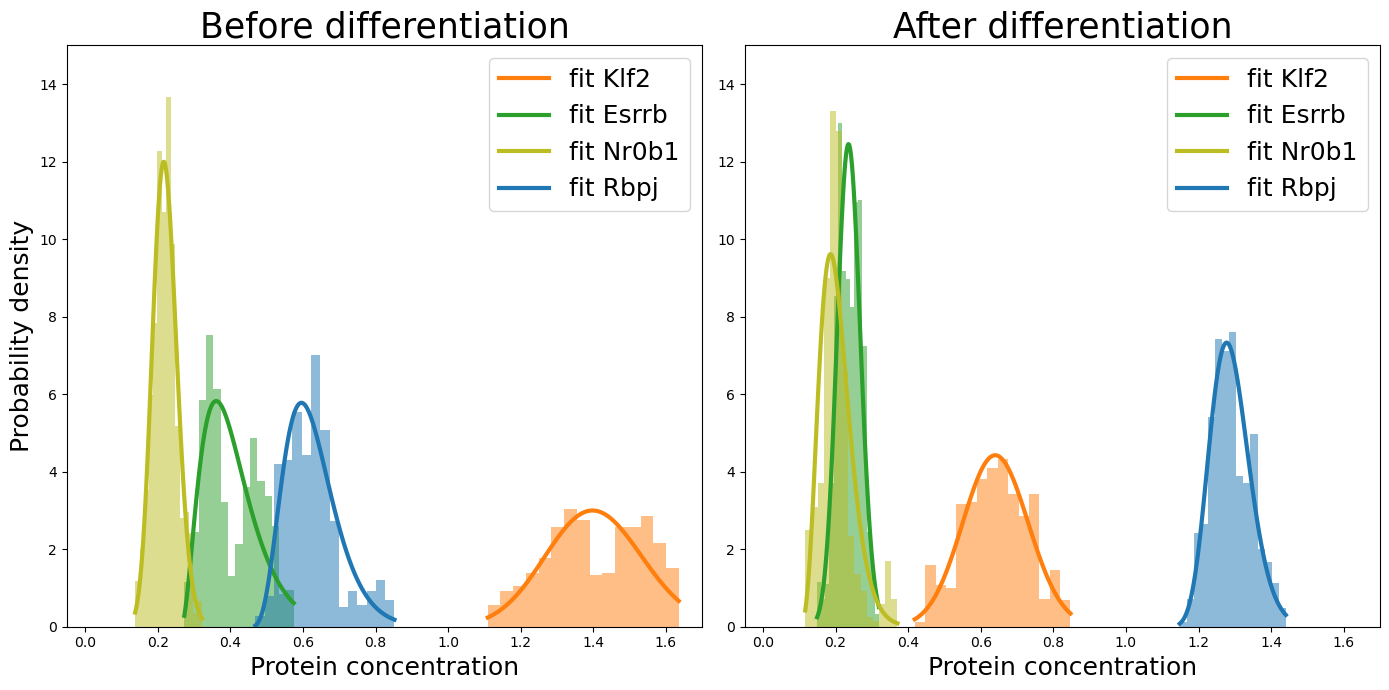

In [25]:
fig, axs = plt.subplots(1,2, figsize=(14,7))

for ii in fancy_indices:

    # plot non differentiated curves
    x0 = np.linspace(np.min(data_nondiff.iloc[:,ii]), np.max(data_nondiff.iloc[:,ii]), num=100)
    a_fit, loc_fit, scale_fit = fit_nondiff.iloc[ii,:][["a","loc","scale"]]
    y_fit = gamma.pdf(x0, a_fit, loc=loc_fit, scale=scale_fit)
    axs[0].hist(data_nondiff.iloc[:,ii], bins=15, density=True, alpha=0.5, color="C"+str(ii))
    axs[0].plot(x0, y_fit, label=f"fit {data_nondiff.columns[ii]}", c="C"+str(ii), lw=3)

    # plot differentiated curves
    x0 = np.linspace(np.min(data_diff.iloc[:,ii]), np.max(data_diff.iloc[:,ii]), num=100)
    a_fit, loc_fit, scale_fit = fit_diff.iloc[ii,:][["a","loc","scale"]]
    y_fit = gamma.pdf(x0, a_fit, loc=loc_fit, scale=scale_fit)
    axs[1].hist(data_diff.iloc[:,ii], bins=15, density=True, alpha=0.5, color="C"+str(ii))
    axs[1].plot(x0, y_fit, label=f"fit {data_diff.columns[ii]}", c="C"+str(ii), lw=3)


for ax in axs.ravel():
    ax.legend()
    ax.set_xlim(-0.05, 1.7)
    ax.set_ylim(0, 15)
    ax.set_xlabel("Protein concentration")

axs[0].set_ylabel("Probability density")
axs[0].set_title("Before differentiation")
axs[1].set_title("After differentiation")
fig.tight_layout()
fig.savefig("images/fancydata_gammafit.jpg", dpi=150)

## Fitting of all the data

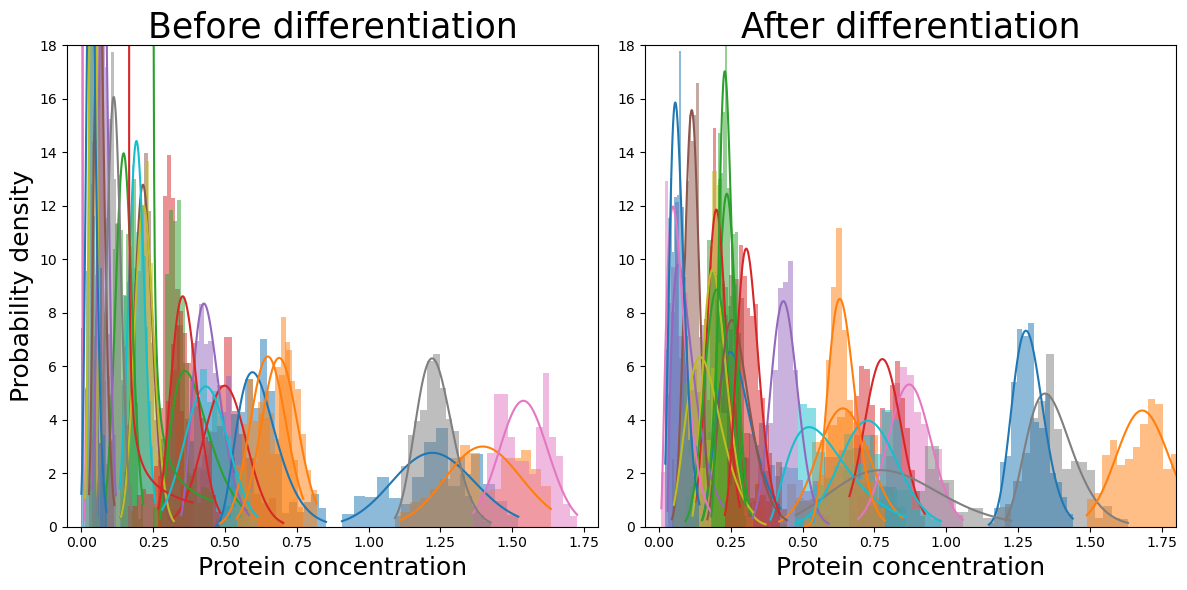

In [7]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

for ii in range(24):

    # plot non differentiated curves
    x0 = np.linspace(np.min(data_nondiff.iloc[:,ii]), np.max(data_nondiff.iloc[:,ii]), num=100)
    a_fit, loc_fit, scale_fit = fit_nondiff.iloc[ii,:][["a","loc","scale"]]
    y_fit = gamma.pdf(x0, a_fit, loc=loc_fit, scale=scale_fit)
    axs[0].hist(data_nondiff.iloc[:,ii], bins=15, density=True, alpha=0.5, color="C"+str(ii))
    axs[0].plot(x0, y_fit, c="C"+str(ii))

    # plot differentiated curves
    x0 = np.linspace(np.min(data_diff.iloc[:,ii]), np.max(data_diff.iloc[:,ii]), num=100)
    a_fit, loc_fit, scale_fit = fit_diff.iloc[ii,:][["a","loc","scale"]]
    y_fit = gamma.pdf(x0, a_fit, loc=loc_fit, scale=scale_fit)
    axs[1].hist(data_diff.iloc[:,ii], bins=15, density=True, alpha=0.5, color="C"+str(ii))
    axs[1].plot(x0, y_fit, c="C"+str(ii))


for ax in axs.ravel():
    ax.set_xlim(-0.05, 1.8)
    ax.set_ylim(0, 18)
    ax.set_xlabel("Protein concentration")

axs[0].set_ylabel("Probability density")
axs[0].set_title("Before differentiation")
axs[1].set_title("After differentiation")
fig.tight_layout()
fig.savefig("images/data_gammafit.jpg", dpi=150)

## Stats of data

In [8]:
stats_nondiff = pd.DataFrame({"mean":[], "var":[], "skew":[], "kurt":[]})
for ii in range(24):
    stat_ = describe(data_nondiff.iloc[:,ii])

    stats_nondiff = pd.concat([
        stats_nondiff,
        pd.DataFrame({"mean":[stat_.mean],
                      "var":[stat_.variance],
                      "skew":[stat_.skewness],
                      "kurt":[stat_.kurtosis]},
                    index=[data_nondiff.columns[ii]])
])

In [9]:
stats_diff = pd.DataFrame({"mean":[], "var":[], "skew":[], "kurt":[]})
for ii in range(24):
    stat_ = describe(data_diff.iloc[:,ii])

    stats_diff = pd.concat([
        stats_diff,
        pd.DataFrame({"mean":[stat_.mean],
                      "var":[stat_.variance],
                      "skew":[stat_.skewness],
                      "kurt":[stat_.kurtosis]},
                    index=[data_diff.columns[ii]])
])

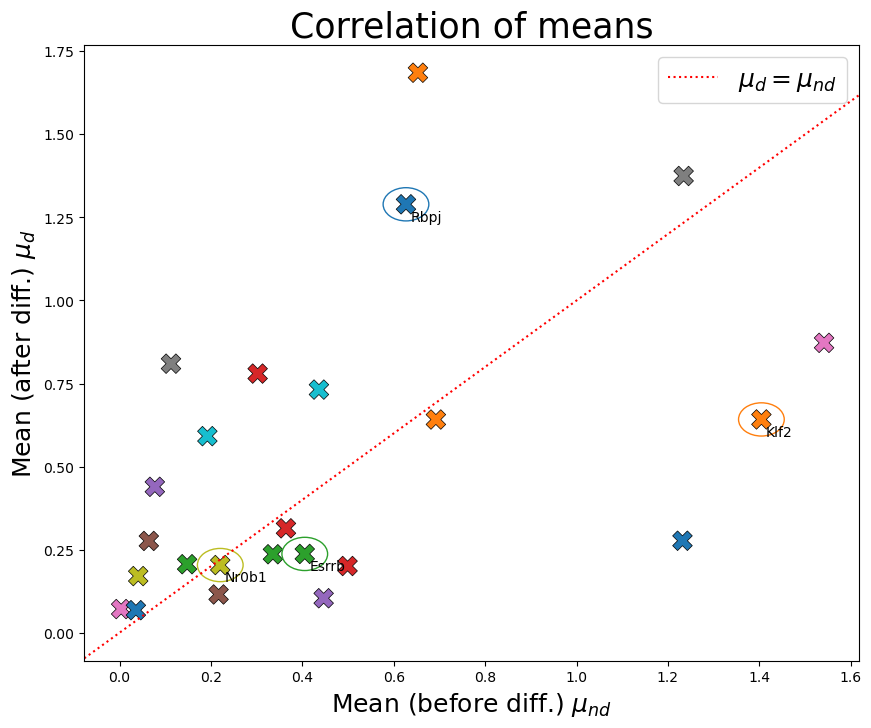

In [26]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(x=stats_nondiff["mean"], y=stats_diff["mean"], s=200, c=["C"+str(c) for c in range(24)] , marker="X", edgecolors="k", linewidths=0.5)
ax.set_title("Correlation of means")
ax.set_xlabel("Mean (before diff.) $\mu_{nd}$")
ax.set_ylabel("Mean (after diff.) $\mu_{d}$")
ax.axline((0,0), slope=1.0, c="red", ls=":", label=r"$\mu_{d} = \mu_{nd}$")
ax.legend()

for ii in fancy_indices:
    c = Circle((stats_nondiff["mean"].iloc[ii], stats_diff["mean"].iloc[ii]), radius=0.05, linewidth=1, facecolor='none', edgecolor="C"+str(ii))
    ax.add_artist(c)
    ax.text(stats_nondiff["mean"].iloc[ii]+0.01, stats_diff["mean"].iloc[ii]-0.05, data_diff.columns[ii])

fig.savefig("images/data_corrmean.jpg", dpi=150)

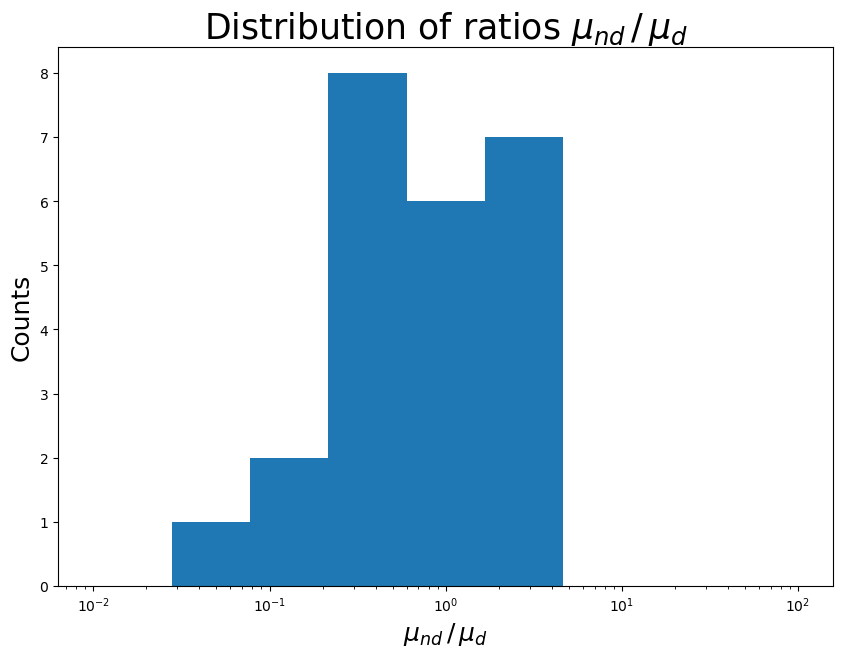

In [14]:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.hist(stats_nondiff["mean"]/stats_diff["mean"], bins=np.logspace(-2,2,10,base=10))
ax.set_title("Distribution of ratios $\mu_{nd}\,/\,\mu_d$")
ax.set_xlabel("$\mu_{nd}\,/\,\mu_d$")
ax.set_ylabel("Counts")
ax.set_xscale("log")
fig.savefig("images/data_ratiomean.jpg", dpi=150)

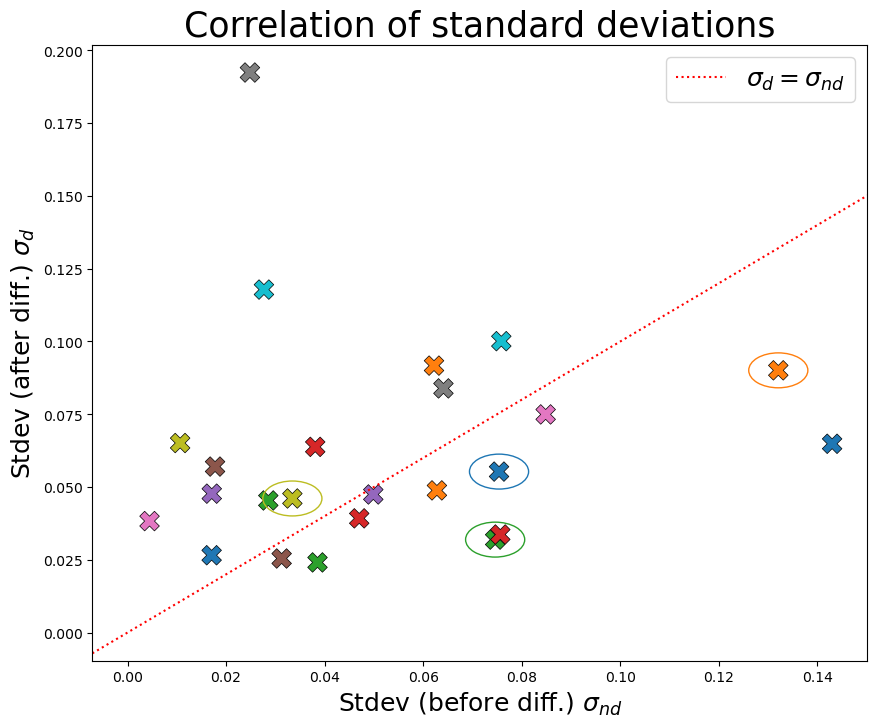

In [28]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(x=np.sqrt(stats_nondiff["var"]), y=np.sqrt(stats_diff["var"]), s=200, c=["C"+str(c) for c in range(24)] , marker="X", edgecolors="k", linewidths=0.5)
ax.set_title("Correlation of standard deviations")
ax.set_xlabel("Stdev (before diff.) $\sigma_{nd}$")
ax.set_ylabel("Stdev (after diff.) $\sigma_{d}$")
ax.axline((0,0), slope=1.0, c="red", ls=":", label=r"$\sigma_{d} = \sigma_{nd}$")
ax.legend()

for ii in fancy_indices:
    c = Circle((np.sqrt(stats_nondiff["var"].iloc[ii]), np.sqrt(stats_diff["var"].iloc[ii])), radius=0.006, linewidth=1, facecolor='none', edgecolor="C"+str(ii))
    ax.add_artist(c)

fig.savefig("images/data_corrstd.jpg", dpi=150)

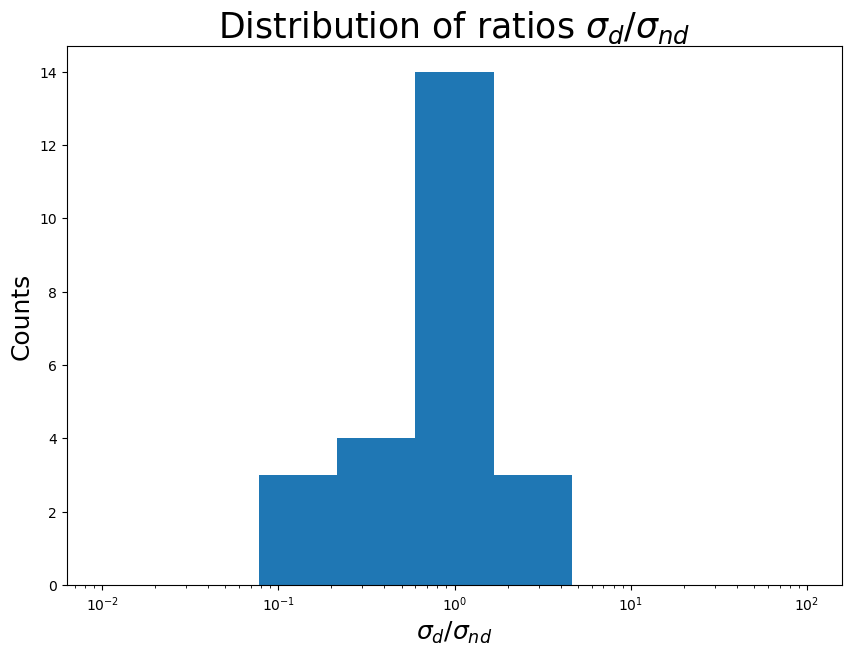

In [16]:
fig, ax = plt.subplots(1, figsize=(10,7))
ax.hist(np.sqrt(stats_nondiff["var"]/stats_diff["var"]), bins=np.logspace(-2,2,10,base=10))
ax.set_title("Distribution of ratios $\sigma_{d} / \sigma_{nd}$")
ax.set_xlabel("$\sigma_{d} / \sigma_{nd}$")
ax.set_ylabel("Counts")
ax.set_xscale("log")
fig.savefig("images/data_ratiostd.jpg", dpi=150)

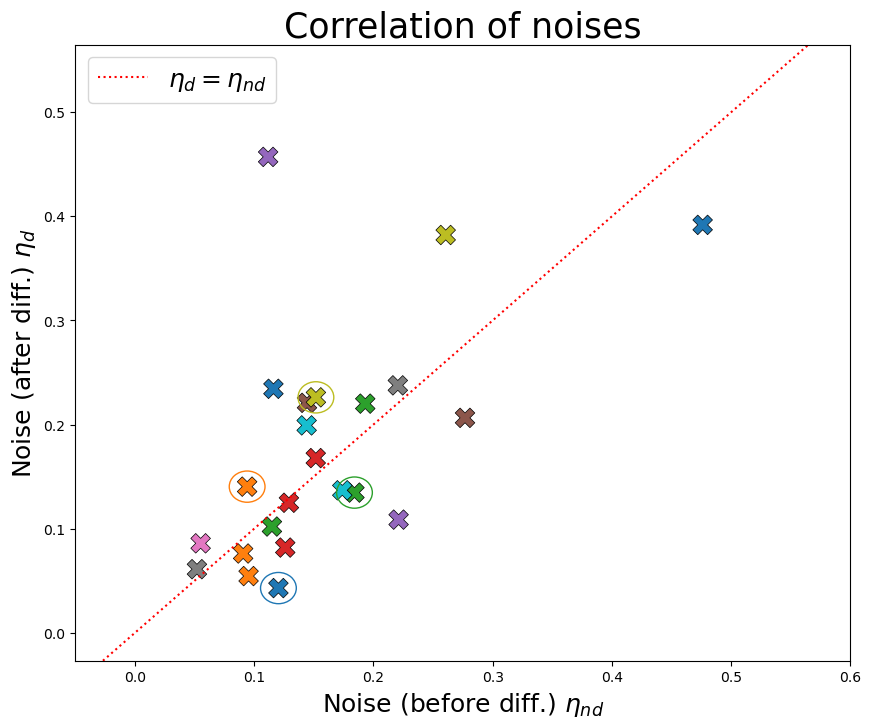

In [29]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(x=np.sqrt(stats_nondiff["var"])/stats_nondiff["mean"], y=np.sqrt(stats_diff["var"])/stats_diff["mean"],
           s=200, c=["C"+str(c) for c in range(24)] , marker="X", edgecolors="k", linewidths=0.5)
ax.set_title("Correlation of noises")
ax.set_xlabel("Noise (before diff.) $\eta_{nd}$")
ax.set_ylabel("Noise (after diff.) $\eta_{d}$")
ax.set_xlim(-0.05,0.6)
ax.axline((0,0), slope=1.0, c="red", ls=":", label=r"$\eta_{d} = \eta_{nd}$")
ax.legend()

for ii in fancy_indices:
    c = Circle(((np.sqrt(stats_nondiff["var"])/stats_nondiff["mean"]).iloc[ii], (np.sqrt(stats_diff["var"])/stats_diff["mean"]).iloc[ii]),
               radius=0.015, linewidth=1, facecolor='none', edgecolor="C"+str(ii))
    ax.add_artist(c)

fig.savefig("images/data_corrnoise.jpg", dpi=150)

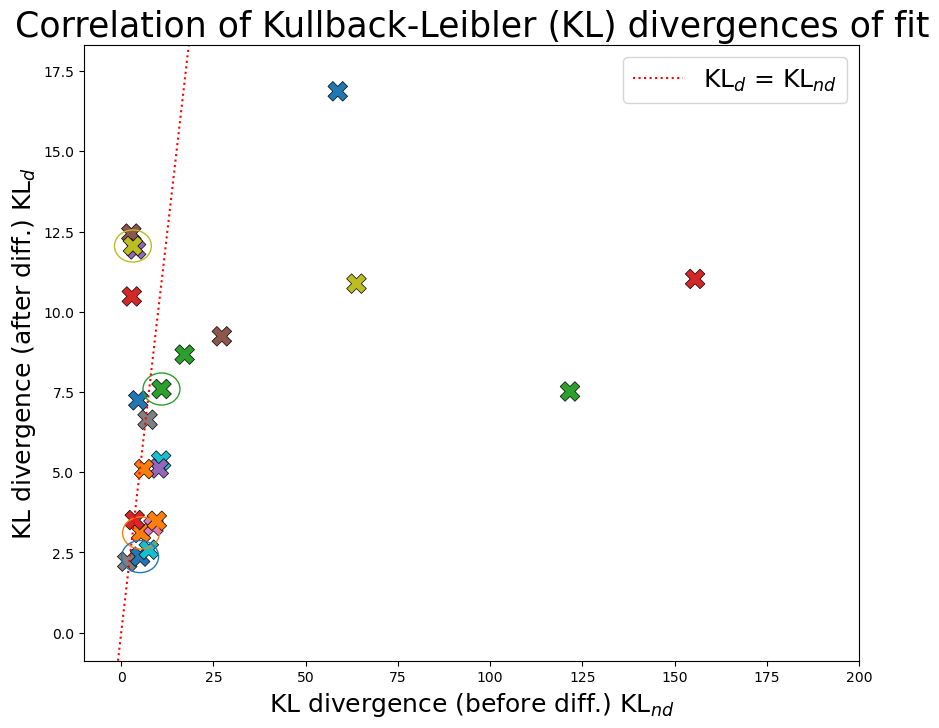

In [30]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(x=fit_nondiff["KL"], y=fit_diff["KL"], s=200, c=["C"+str(c) for c in range(24)] , marker="X", edgecolors="k", linewidths=0.5)
ax.set_title("Correlation of Kullback-Leibler (KL) divergences of fit")
ax.set_xlabel("KL divergence (before diff.) KL$_{nd}$")
ax.set_ylabel("KL divergence (after diff.) KL$_{d}$")
ax.axline((0,0), slope=1.0, c="red", ls=":", label=r"KL$_{d}$ = KL$_{nd}$")
ax.set_xlim(-10,200)
ax.legend()

for ii in fancy_indices:
    c = Ellipse((fit_nondiff["KL"].iloc[ii],fit_diff["KL"].iloc[ii]),
               width=10, height=1, linewidth=1, facecolor='none', edgecolor="C"+str(ii))
    ax.add_artist(c)

fig.savefig("images/data_corrKL.jpg", dpi=150)

## Bimodality index with R
Run ```BimodalIndex.r``` from terminal to compute this index.

In [19]:
BI_df = pd.read_csv("results/BimodalIndex_result.csv", index_col=0)
BI_df

,mu1_nondiff,mu2_nondiff,sigma_nondiff,delta_nondiff,pi_nondiff,BI_nondiff,mu1_diff,mu2_diff,sigma_diff,delta_diff,pi_diff,BI_diff
Klf4,1.065905,1.304753,0.091254,2.617402,0.305602,1.205737,0.239231,0.355463,0.035315,3.291334,0.676440,1.539798
Klf2,1.295957,1.516290,0.072777,3.027498,0.507610,1.513574,0.579402,0.699864,0.066952,1.799226,0.480700,0.898943
Esrrb,0.346581,0.481247,0.033190,4.057409,0.563747,2.012149,0.211754,0.261694,0.019877,2.512367,0.490795,1.255971
Tfcp2l1,0.454423,0.532619,0.064958,1.203793,0.429947,0.595960,0.182518,0.226569,0.025740,1.711396,0.585054,0.843227
Tbx3,0.418623,0.500422,0.031263,2.616448,0.656933,1.242116,0.071539,0.152058,0.026290,3.062754,0.599335,1.500851
Stat3,0.202976,0.232487,0.027573,1.070274,0.531989,0.534041,0.087355,0.123401,0.020413,1.765892,0.228761,0.741737
Nanog,1.469183,1.619031,0.039853,3.760064,0.517220,1.878917,0.837291,0.911141,0.065291,1.131091,0.524803,0.564849
Sox2,1.202574,1.289233,0.048617,1.782476,0.633668,0.858800,1.337835,1.481594,0.055618,2.584737,0.744175,1.127783
Nr0b1,0.212053,0.259947,0.028041,1.708041,0.824698,0.649441,0.194804,0.335673,0.030783,4.576134,0.936122,1.119031
Zic3,0.170668,0.213792,0.017336,2.487513,0.499491,1.243756,0.516127,0.724292,0.062233,3.344909,0.637731,1.607751


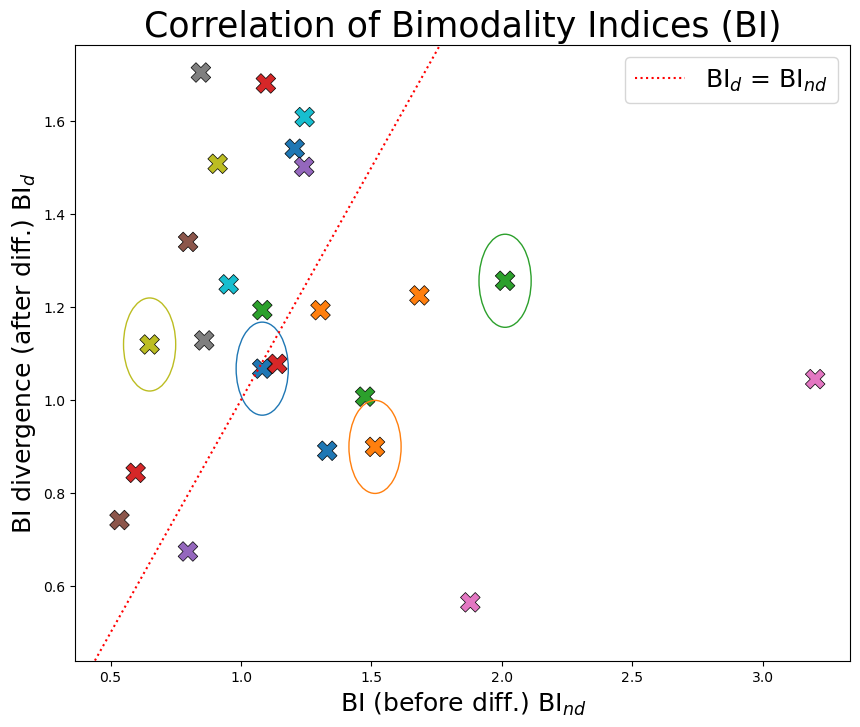

In [31]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(x=BI_df["BI_nondiff"], y=BI_df["BI_diff"], s=200, c=["C"+str(c) for c in range(24)] , marker="X", edgecolors="k", linewidths=0.5)
ax.set_title("Correlation of Bimodality Indices (BI)")
ax.set_xlabel("BI (before diff.) BI$_{nd}$")
ax.set_ylabel("BI divergence (after diff.) BI$_{d}$")
ax.axline((0.5,0.5), slope=1.0, c="red", ls=":", label=r"BI$_{d}$ = BI$_{nd}$")
ax.legend()

for ii in fancy_indices:
    c = Circle((BI_df["BI_nondiff"].iloc[ii], BI_df["BI_diff"].iloc[ii]),
               radius=0.1, linewidth=1, facecolor='none', edgecolor="C"+str(ii))
    ax.add_artist(c)

fig.savefig("images/data_corrBI.jpg", dpi=150)